# Investigation of a bias in ARFs

- by obtaining codon frequencies and codon pair frequencies in non-overlapping regions of canonical ORFs ([previous notebook](./210527_1_count_freqs.ipynb))
- then, by calculating the expected codon pair frequency and ARF codon frequency (this notebook)


In [1]:
import numpy as np
import pandas as pd
from pyscripts.config import path2
from pyscripts.genomeutil import bac_translate
from Bio.Seq import reverse_complement

In [2]:
nts_summary = pd.read_pickle(path2.data/'kmer'/'nts_summary.pkl.bz2')
codons_summary = pd.read_pickle(path2.data/'kmer'/'codons_summary.pkl.bz2')
bicodons_summary = pd.read_pickle(path2.data/'kmer'/'bicodons_summary.pkl.bz2')

In [3]:
codon_usage = codons_summary / codons_summary.groupby(bac_translate).transform('sum')

obs_bicodons = bicodons_summary
exp_bicodons = bicodons_summary.groupby(bac_translate).transform('sum') \
                * bicodons_summary.index.to_series().str[:3].apply(lambda c: codon_usage.loc[c]) \
                * bicodons_summary.index.to_series().str[3:].apply(lambda c: codon_usage.loc[c])

In [4]:
fw1 = lambda bc: bac_translate(bc[1:4])
fw2 = lambda bc: bac_translate(bc[2:5])
rc1 = lambda bc: bac_translate(reverse_complement(bc[1:4]))
rc2 = lambda bc: bac_translate(reverse_complement(bc[2:5]))

In [5]:
Z_stop = pd.DataFrame(dtype=float)

for frame, arf in zip(['+1','+2','-1','-2'], [fw1, fw2, rc1, rc2]):
    obs_aa = obs_bicodons.groupby(arf).sum()
    exp_aa = exp_bicodons.groupby(arf).sum()
    assert np.isclose(obs_aa.sum(), exp_aa.sum()).all()
    N = exp_aa.sum()
    
    obs_stop, obs_nonstop = obs_aa.loc['*'], obs_aa.sum() - obs_aa.loc['*']
    exp_stop, exp_nonstop = exp_aa.loc['*'], exp_aa.sum() - exp_aa.loc['*']
    
    Z_stop[frame] = (obs_stop - exp_stop) / np.sqrt((N * exp_stop - exp_stop ** 2) / (N - 1))
    

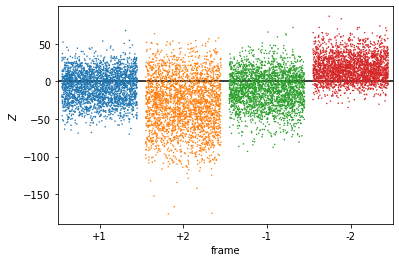

In [8]:
import seaborn as sns

ax = sns.stripplot(
    x='frame', y='$Z$', jitter=0.45, s=1.5,
    data=Z_stop.rename_axis('frame', axis=1).unstack().rename('$Z$').reset_index()
)

ax.axhline(0, c='k')

- Reproducibility was confirmed. 
- Will upgrade the figure somewhere in '07-figures/'